Using device: cuda
Training on Food101 images.
Targeting ImageNet class: 'tench' (ID: 957)
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\DEVESH\anaconda3\Lib\site-packages\lpips\weights\v0.1\vgg.pth


Optimizing Patch: 100%|██████████| 1500/1500 [28:07<00:00,  1.12s/it, Total Loss=16.366, Cls Loss=3.277, Attn Loss=-0.017]



Optimization finished.
Saved optimized patch to 'adversarial_patch.pt'
Saved patch visualization to 'adversarial_patch.png'
Saved final attack visualization to 'patch_attack_result.png'


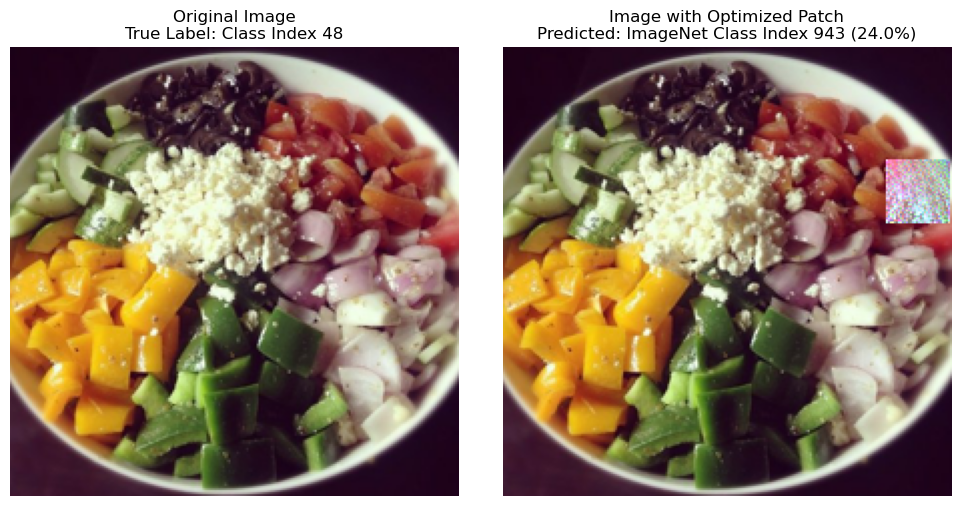

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import lpips  # For perceptual loss
from types import MethodType

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = 'vit_base_patch16_224'
DATASET = 'Food101'
PATCH_SIZE = 32
BATCH_SIZE = 16
LEARNING_RATE = 0.001
MAX_ITERATIONS = 1500 # <-- Increased iterations for balanced optimization
TARGET_LABEL = 957 # 'spaghetti'

# "Stealthy Nudge" attack settings
W_ATTENTION = 1.0
W_PERCEPTUAL = 10.0 # <-- RE-ACTIVATED for stealth
W_CLASSIFICATION = 5.0

print(f"Using device: {DEVICE}")

# --- 1. Custom ViT Model to Extract Attention (FIXED) ---
class CustomViT(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        
        last_block_attn = self.model.blocks[-1].attn
        def new_forward(self, x):
            B, N, C = x.shape
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            self.attention_map_saved = attn
            attn = self.attn_drop(attn)
            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x
        last_block_attn.forward = MethodType(new_forward, last_block_attn)

    def forward(self, x):
        logits = self.model(x)
        attention_maps = self.model.blocks[-1].attn.attention_map_saved
        return logits, attention_maps

# --- 2. Load Model, Data, and Preprocessing ---
model = CustomViT(MODEL_NAME).to(DEVICE)
model.eval()

data_config = timm.data.resolve_model_data_config(model.model)
transform = timm.data.create_transform(**data_config, is_training=False)

if DATASET == 'Food101':
    # Food-101 is a realistic dataset with a reliable download link.
    dataset = torchvision.datasets.Food101(root="./data", split='train', download=True, transform=transform)
    print(f"Training on {DATASET} images.")
else:
    raise NotImplementedError(f"Dataset {DATASET} not configured.")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Targeting ImageNet class: 'tench' (ID: {TARGET_LABEL})")

# --- 3. Initialize The Patch and Optimizer ---
adversarial_patch = torch.rand(3, PATCH_SIZE, PATCH_SIZE, requires_grad=True, device=DEVICE)
optimizer = optim.Adam([adversarial_patch], lr=LEARNING_RATE)
lpips_loss_fn = lpips.LPIPS(net='vgg').to(DEVICE)

# --- 4. The Optimization Loop ---
pbar = tqdm(range(MAX_ITERATIONS), desc="Optimizing Patch")
data_iterator = iter(dataloader)
for iteration in pbar:
    try:
        images, _ = next(data_iterator)
    except StopIteration:
        data_iterator = iter(dataloader)
        images, _ = next(data_iterator)
        
    images = images.to(DEVICE)

    patched_images = []
    patch_masks = []
    
    img_height, img_width = data_config['input_size'][1:]
    for img in images:
        start_x = random.randint(0, img_width - PATCH_SIZE)
        start_y = random.randint(0, img_height - PATCH_SIZE)
        
        patched_img = img.clone()
        patched_img[:, start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE] = adversarial_patch
        patched_images.append(patched_img)
        
        mask = torch.zeros(1, 1, img_height, img_width, device=DEVICE)
        mask[:, :, start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE] = 1
        mask = F.max_pool2d(mask, kernel_size=16)
        patch_masks.append(mask.flatten())

    patched_images = torch.stack(patched_images)
    patch_masks = torch.stack(patch_masks)

    logits, attention_maps = model(patched_images)
    
    target_labels = torch.full((images.size(0),), TARGET_LABEL, dtype=torch.long, device=DEVICE)
    loss_classification = nn.CrossEntropyLoss()(logits, target_labels)

    cls_attention = attention_maps[:, :, 0, 1:]
    cls_attention = cls_attention.mean(dim=1)
    attention_on_patch = (cls_attention * patch_masks).sum(dim=1) / patch_masks.sum(dim=1)
    loss_attention = -attention_on_patch.mean()

    total_loss = (W_CLASSIFICATION * loss_classification + 
                  W_ATTENTION * loss_attention)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    adversarial_patch.data.clamp_(0, 1)
    
    pbar.set_postfix({
        "Total Loss": f"{total_loss.item():.3f}",
        "Cls Loss": f"{loss_classification.item():.3f}",
        "Attn Loss": f"{loss_attention.item():.3f}",
    })

# --- 5. Save and Visualize the Final Patch ---
print("\nOptimization finished.")
torch.save(adversarial_patch.detach(), "adversarial_patch.pt")
print("Saved optimized patch to 'adversarial_patch.pt'")

patch_pil = transforms.ToPILImage()(adversarial_patch.detach().cpu())
patch_pil.save("adversarial_patch.png")
print("Saved patch visualization to 'adversarial_patch.png'")

def tensor_to_pil(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    mean = torch.tensor(data_config['mean'])
    std = torch.tensor(data_config['std'])
    tensor = tensor * std[:, None, None] + mean[:, None, None]
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

# --- Visualize the patch effect on a test image ---
test_dataset = torchvision.datasets.Food101(root="./data", split='test', download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

sample_img_tensor, true_label_idx = next(iter(test_dataloader))
sample_img_tensor = sample_img_tensor.to(DEVICE)
true_label_name = f"Class Index {true_label_idx.item()}"

start_x = random.randint(0, data_config['input_size'][1] - PATCH_SIZE)
start_y = random.randint(0, data_config['input_size'][2] - PATCH_SIZE)
patched_test_tensor = sample_img_tensor.clone()
patched_test_tensor[0, :, start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE] = adversarial_patch.detach()

logits, _ = model(patched_test_tensor)
pred_prob = torch.softmax(logits, dim=1)
pred_label_idx = torch.argmax(pred_prob).item()
pred_label_name = f"ImageNet Class Index {pred_label_idx}" 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(tensor_to_pil(sample_img_tensor))
ax1.set_title(f"Original Image\nTrue Label: {true_label_name}")
ax1.axis('off')

ax2.imshow(tensor_to_pil(patched_test_tensor))
ax2.set_title(f"Image with Optimized Patch\nPredicted: {pred_label_name} ({pred_prob.max()*100:.1f}%)")
ax2.axis('off')

plt.tight_layout()
plt.savefig("patch_attack_result.png")
print("Saved final attack visualization to 'patch_attack_result.png'")